In [1]:
import os
import glob
import pandas as pd
import numpy as np

from functions_jonne import createwells
from functions_jonne import plot_plates

os.chdir('./output')

In [2]:
path = ('infection_rate') 
if not os.path.exists(path):
    os.mkdir(path)
    print('folder created')

In [4]:
dfs = []
cols = ["Metadata_plate_map_name","Metadata_Well","Metadata_Site","Nuclei_AreaShape_Area","Cytoplasm_Intensity_MeanIntensity_ER"]

for filename in os.listdir('../output/'):
    if filename.endswith('.parquet') and filename.startswith("level1_agg"):
        filepath = os.path.join('../output/', filename)
        df = pd.read_parquet(filepath)
        df = df.filter([col for col in df.columns if col in cols])
        
        # Drop the first row and any rows with NA values
        df = df.drop(0)
        df = df.dropna()

        dfs.append(df)

In [ ]:
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df.to_csv("infection_subset.csv")

In [5]:
#------------------- remove QC flagged images -------------------#

Flags =  pd.read_csv('../QC/level0_passed.csv', sep = ',')
Flags['ImageID'] =  Flags['Metadata_plate_map_name'] + "_" + Flags['Metadata_Well'] + "_s" + Flags['Metadata_Site'].astype(str).str.rstrip('.0')
Flags[["flag"]]  =  0
Flags = Flags[["ImageID", "flag"]]
flaggeddict = dict(Flags.values)

In [6]:
df['ImageID'] = df['Metadata_plate_map_name'] + "_" + df['Metadata_Well'] + "_s" + df['Metadata_Site'].astype(str).str.rstrip('.0')
df["flag"]    = df["ImageID"].map(flaggeddict)
df            = df[df['flag'] == 0]
df.drop('flag', axis=1, inplace=True)

In [7]:
#------------------- add metadata -------------------#

meta = pd.read_csv('../metadata/LABDESIGN_metadata_SSS-A549-v2.csv', low_memory=False, sep=",") # change for each exp
meta = meta.rename(columns={
                     "barcode": "Metadata_plate_map_name",
                     "batch_id": "Metadata_cmpdName",
                     "well_id": "Metadata_Well",
                     "cell_line": "Metadata_CellLine",
                     "cmpd_conc": "Metadata_cmpdConc",
                     "cells_per_well": "Metadata_CellDensity"},
            errors="raise")

meta = meta[['Metadata_plate_map_name','Metadata_cmpdName','Metadata_cmpdConc','Metadata_Well']]

In [8]:
initial_shape = df.shape[0]  
df            = pd.merge(left=meta, right=df, left_on=['Metadata_plate_map_name','Metadata_Well'], right_on=['Metadata_plate_map_name','Metadata_Well'])
final_shape   = df.shape[0] 

print(f"Final number of rows after merging = {final_shape}")
if initial_shape == final_shape:
    print(f"All rows successfully matched with metadata.")
else:
    print(f"WARNING! {initial_shape - final_shape} rows were not matched with metadata.")

Final number of rows after merging = 13990834
All rows successfully matched with metadata.


In [14]:
df.to_csv("ab.csv")

# plot ab

In [10]:
df = pd.read_csv("../output/ab.csv")

In [11]:
def calculate_threshold(group):
    mean_value = group['Cytoplasm_Intensity_MeanIntensity_ER'].mean()
    std_value  = group['Cytoplasm_Intensity_MeanIntensity_ER'].std()
    threshold_value = mean_value + 3 * std_value
    return threshold_value

uninfected = df[(df['Metadata_Well'].str.contains('08|16')) & (df['Metadata_cmpdName'] == 'DMSO')]
infected   = df[(~df['Metadata_Well'].str.contains('08|16')) & (df['Metadata_cmpdName'] == 'DMSO')]
#infected   = infected.sample(frac=0.5, random_state=1) # take 10% sample

In [12]:
lower_bound      = uninfected['Cytoplasm_Intensity_MeanIntensity_ER'].quantile(0.025)
upper_bound      = uninfected['Cytoplasm_Intensity_MeanIntensity_ER'].quantile(0.975)
clipped_df       = uninfected[(uninfected['Cytoplasm_Intensity_MeanIntensity_ER'] >= lower_bound) & (uninfected['Cytoplasm_Intensity_MeanIntensity_ER'] <= upper_bound)]
mean_intensity   = clipped_df['Cytoplasm_Intensity_MeanIntensity_ER'].mean()
stddev_intensity = clipped_df['Cytoplasm_Intensity_MeanIntensity_ER'].std()

#mean_intensity   = uninfected['Cytoplasm_Intensity_MeanIntensity_ER'].mean()
#stddev_intensity = uninfected['Cytoplasm_Intensity_MeanIntensity_ER'].std()

mean_plus_3xstddev = mean_intensity + 1 * stddev_intensity
mean_intensity, stddev_intensity, mean_plus_3xstddev

threshold = mean_plus_3xstddev
threshold

np.float64(0.030366847829601622)

In [13]:
mean_intensity

np.float64(0.027444657549114154)

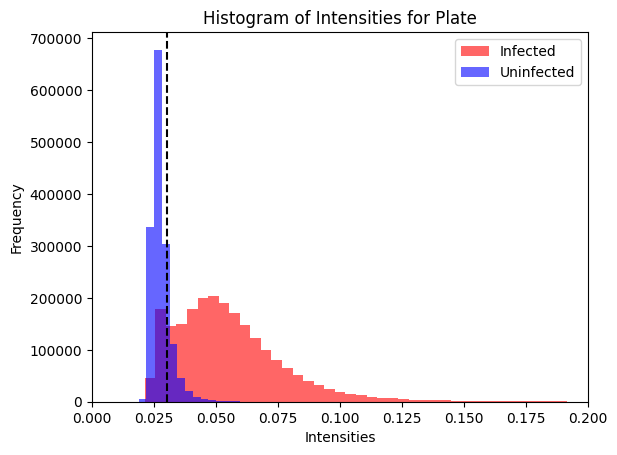

In [15]:
num_bins = 200

plt.hist(infected['Cytoplasm_Intensity_MeanIntensity_ER'],   bins=num_bins, color='red', alpha=0.6, label='Infected')
plt.hist(uninfected['Cytoplasm_Intensity_MeanIntensity_ER'], bins=num_bins, color='blue', alpha=0.6, label='Uninfected')
plt.xlim(0, 0.2)
plt.xlabel('Intensities')
plt.ylabel('Frequency')
plt.title(f'Histogram of Intensities for Plate')
plt.legend()
    
# Add vertical line for the threshold value
plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    
plt.show()

### add label based on cut-off (cell level)

In [16]:
df['Threshold'] = threshold
df

,Unnamed: 0,Metadata_plate_map_name,Metadata_cmpdName,Metadata_cmpdConc,Metadata_Well,Metadata_Site,Nuclei_AreaShape_Area,Cytoplasm_Intensity_MeanIntensity_ER,ImageID,Threshold
0,0,P103555,BJ1897253,10.0,A02,1.0,1917.0,0.037004,P103555_A02_s1,0.030367
1,1,P103555,BJ1897253,10.0,A02,1.0,1553.0,0.027456,P103555_A02_s1,0.030367
2,2,P103555,BJ1897253,10.0,A02,1.0,1762.0,0.028357,P103555_A02_s1,0.030367
3,3,P103555,BJ1897253,10.0,A02,1.0,1713.0,0.038942,P103555_A02_s1,0.030367
4,4,P103555,BJ1897253,10.0,A02,1.0,837.0,0.038457,P103555_A02_s1,0.030367
...,...,...,...,...,...,...,...,...,...,...
13995120,13995120,P103588,DMSO,0.3,P23,9.0,1132.5,0.041095,P103588_P23_s9,0.030367
13995121,13995121,P103588,DMSO,0.3,P23,9.0,2415.0,0.060193,P103588_P23_s9,0.030367
13995122,13995122,P103588,DMSO,0.3,P23,9.0,1601.0,0.063211,P103588_P23_s9,0.030367
13995123,13995123,P103588,DMSO,0.3,P23,9.0,2638.0,0.049645,P103588_P23_s9,0.030367


In [17]:
df['infected'] = df.apply(lambda row: 1 if row['Cytoplasm_Intensity_MeanIntensity_ER'] > row['Threshold'] else 0, axis=1)
df

,Unnamed: 0,Metadata_plate_map_name,Metadata_cmpdName,Metadata_cmpdConc,Metadata_Well,Metadata_Site,Nuclei_AreaShape_Area,Cytoplasm_Intensity_MeanIntensity_ER,ImageID,Threshold,infected
0,0,P103555,BJ1897253,10.0,A02,1.0,1917.0,0.037004,P103555_A02_s1,0.030367,1
1,1,P103555,BJ1897253,10.0,A02,1.0,1553.0,0.027456,P103555_A02_s1,0.030367,0
2,2,P103555,BJ1897253,10.0,A02,1.0,1762.0,0.028357,P103555_A02_s1,0.030367,0
3,3,P103555,BJ1897253,10.0,A02,1.0,1713.0,0.038942,P103555_A02_s1,0.030367,1
4,4,P103555,BJ1897253,10.0,A02,1.0,837.0,0.038457,P103555_A02_s1,0.030367,1
...,...,...,...,...,...,...,...,...,...,...,...
13995120,13995120,P103588,DMSO,0.3,P23,9.0,1132.5,0.041095,P103588_P23_s9,0.030367,1
13995121,13995121,P103588,DMSO,0.3,P23,9.0,2415.0,0.060193,P103588_P23_s9,0.030367,1
13995122,13995122,P103588,DMSO,0.3,P23,9.0,1601.0,0.063211,P103588_P23_s9,0.030367,1
13995123,13995123,P103588,DMSO,0.3,P23,9.0,2638.0,0.049645,P103588_P23_s9,0.030367,1


In [18]:
#add column for cell count
df['cellcount'] = 1

# Aggregate profiles

### aggregate to well level

In [19]:
# COUNT INFECTED CELLS (well level)

dfmeanW = df.groupby(['Metadata_plate_map_name', 'Metadata_Well','Metadata_cmpdName','Metadata_cmpdConc']).sum()
dfmeanW = dfmeanW.reset_index() 

dfmeanW.head(5)

,Metadata_plate_map_name,Metadata_Well,Metadata_cmpdName,Metadata_cmpdConc,Unnamed: 0,Metadata_Site,Nuclei_AreaShape_Area,Cytoplasm_Intensity_MeanIntensity_ER,ImageID,Threshold,infected,cellcount
0,P103555,A02,BJ1897253,10.000000,2191371,10816.0,3.814950e+06,104.872991,P103555_A02_s1P103555_A02_s1P103555_A02_s1P103...,63.588179,1621,2094
1,P103555,A03,BJ1897660,3.333333,4555930,7954.0,2.776505e+06,102.109471,P103555_A03_s1P103555_A03_s1P103555_A03_s1P103...,47.979620,1504,1580
2,P103555,A04,BJ1897822,0.100000,4398980,5338.0,1.976699e+06,33.072447,P103555_A04_s1P103555_A04_s1P103555_A04_s1P103...,31.824457,484,1048
3,P103555,A05,BJ1897652,10.000000,9177219,8386.0,2.657586e+06,65.407755,P103555_A05_s1P103555_A05_s1P103555_A05_s1P103...,50.226766,1039,1654
4,P103555,A06,BJ1894117,10.000000,10790716,7687.0,2.564302e+06,100.743067,P103555_A06_s1P103555_A06_s1P103555_A06_s1P103...,45.945041,1432,1513


In [20]:
dfmeanW["infection_percentage"] = (dfmeanW["infected"] / dfmeanW["cellcount"] * 100).round()
dfmeanW.head(5)

,Metadata_plate_map_name,Metadata_Well,Metadata_cmpdName,Metadata_cmpdConc,Unnamed: 0,Metadata_Site,Nuclei_AreaShape_Area,Cytoplasm_Intensity_MeanIntensity_ER,ImageID,Threshold,infected,cellcount,infection_percentage
0,P103555,A02,BJ1897253,10.000000,2191371,10816.0,3.814950e+06,104.872991,P103555_A02_s1P103555_A02_s1P103555_A02_s1P103...,63.588179,1621,2094,77.0
1,P103555,A03,BJ1897660,3.333333,4555930,7954.0,2.776505e+06,102.109471,P103555_A03_s1P103555_A03_s1P103555_A03_s1P103...,47.979620,1504,1580,95.0
2,P103555,A04,BJ1897822,0.100000,4398980,5338.0,1.976699e+06,33.072447,P103555_A04_s1P103555_A04_s1P103555_A04_s1P103...,31.824457,484,1048,46.0
3,P103555,A05,BJ1897652,10.000000,9177219,8386.0,2.657586e+06,65.407755,P103555_A05_s1P103555_A05_s1P103555_A05_s1P103...,50.226766,1039,1654,63.0
4,P103555,A06,BJ1894117,10.000000,10790716,7687.0,2.564302e+06,100.743067,P103555_A06_s1P103555_A06_s1P103555_A06_s1P103...,45.945041,1432,1513,95.0


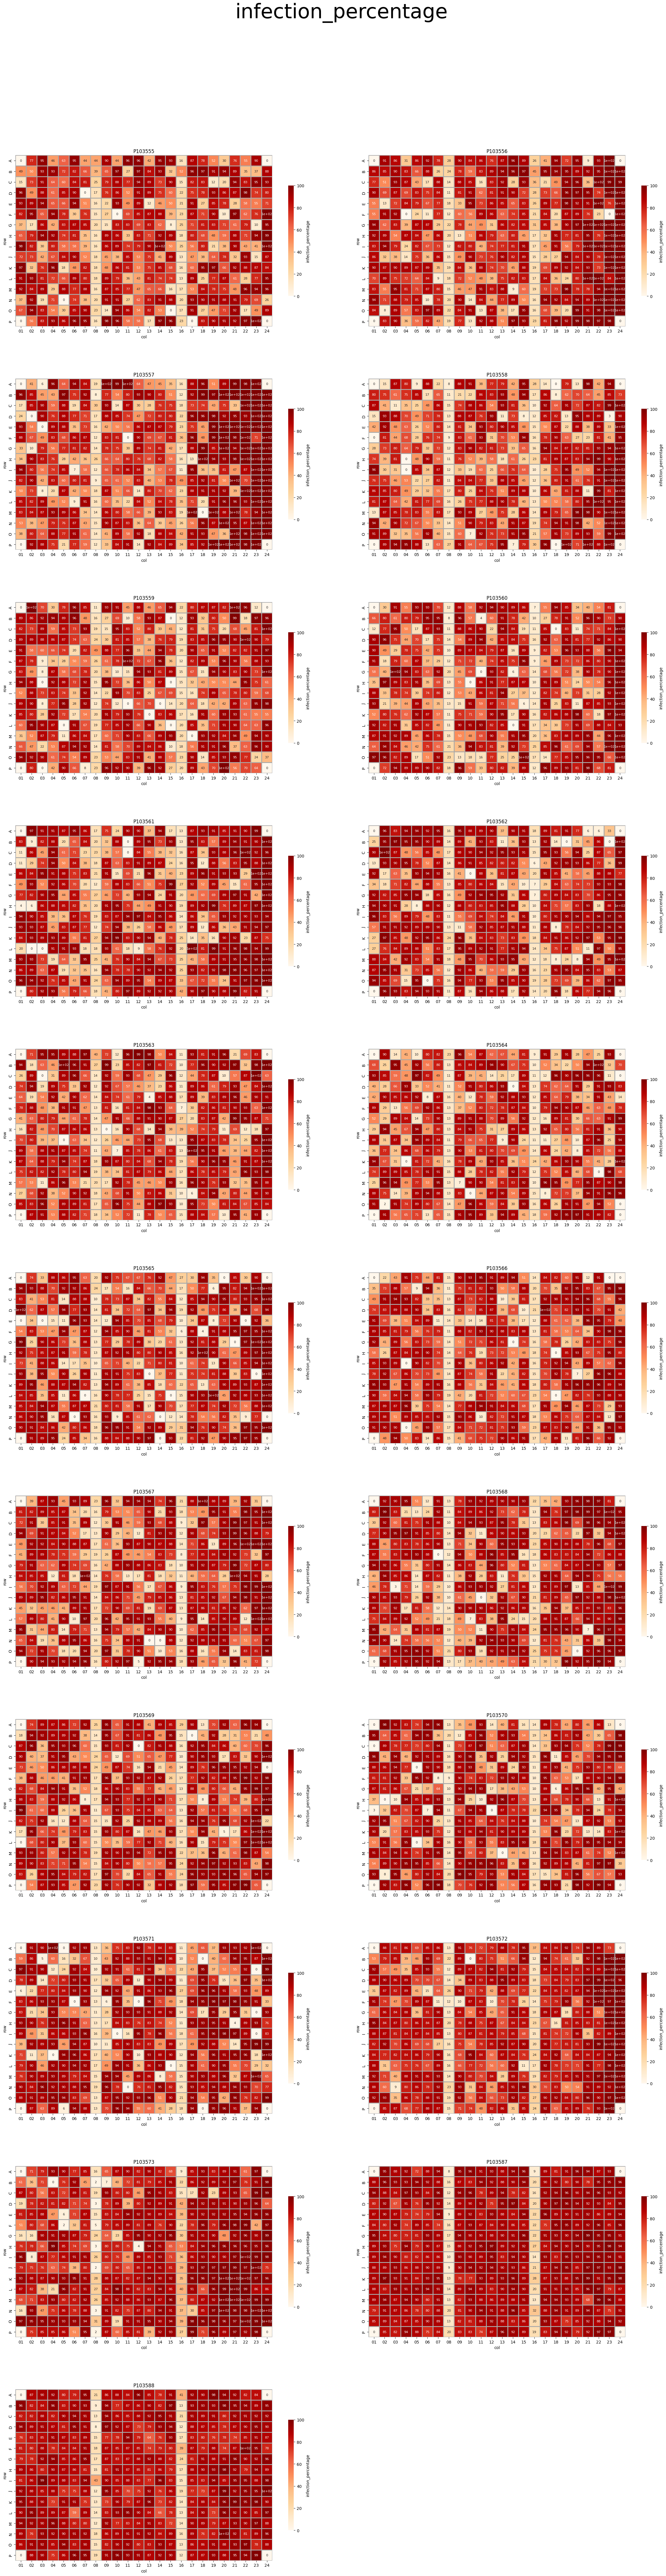

In [25]:
selected_features = [col for col in dfmeanW.columns if col.startswith('infection_percentage')]

for feature in selected_features:
    plot_plates(dfmeanW, "infection_percentage")

### normalize values to DMSO (+virus) wells

In [28]:
dfmeanCmp = dfmeanW.copy()

dfmeanCmp['perc_infected'] = dfmeanCmp['infected']/dfmeanCmp['cellcount']*100
dfmeanCmp.head(5)

DMSO_percinfected = dfmeanCmp.loc[dfmeanCmp.Metadata_cmpdName=="DMSO", 'perc_infected'].values[0]
#DMSO_percinfected = 80.0
print("the percentage of infected cells in DMSO equals:", DMSO_percinfected.round(), "%")

DMSO_count = dfmeanCmp.loc[(~dfmeanCmp['Metadata_Well'].str.contains('12')), 'cellcount'].values[0]
print("the average cell count of infected cells in DMSO per image equals:", DMSO_count.round())

dfmeanCmp['cellcount_norm']    = (100*dfmeanCmp['cellcount'])/DMSO_count
dfmeanCmp['Percinfected_norm'] = (100*dfmeanCmp['perc_infected'])/DMSO_percinfected

#dfmeanCmp = dfmeanCmp.round()
#dfmeanCmp.head(15)

the percentage of infected cells in DMSO equals: 44.0 %
the average cell count of infected cells in DMSO per image equals: 2094


In [29]:
dfmeanCmp.to_csv("infection_scores.csv")